# Implementation of BB84 on Starmon-5

In [1]:
###                                                   IMPORTING LIBRARIES
import time
import os
import numpy as np
import random
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import plot_histogram

from quantuminspire.credentials import get_authentication
from quantuminspire.credentials import save_account
from quantuminspire.qiskit import QI

from math import ceil
from itertools import product

In [2]:
###                                             CONNECTING TO QUANTUM INSPIRE
save_account('a2c6982402352e8e4b3bcabb8e89d7ec75d93003')
QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')
authentication = get_authentication()
QI.set_authentication(authentication, QI_URL,project_name='BB84 Simulation')
qi_backend = QI.get_backend('QX-34-L')                                       # <--- Set the backend (default is Starmon-5)

## Circuit construction (with quantum randomness)

In [3]:
def IntrinsicQuantumBB84Circuit(numMeasurements, isEve):
   
    """
    Circuit Generator
    
    For Starmon5 purposes only
    
    p.....Probability that Eve gets the qubit
    """
    q = QuantumRegister(5)
    ans = ClassicalRegister(5)
    qc = QuantumCircuit(q, ans)
    
    qc.h(q[0])
    qc.h(q[1])
    qc.h(q[2])

    qc.measure(q[0],ans[0])
    qc.measure(q[1],ans[1])
    qc.measure(q[2],ans[2])

    for level in range(numMeasurements):
        
        qc.x(q[3]).c_if(ans[0],1)
        qc.h(q[3]).c_if(ans[1],1)
        qc.h(q[3]).c_if(ans[2],1)

        if isEve:
            qc.h(q[4])
            qc.measure(q[4],ans[4])
            qc.ch(q[4],q[2])
            qc.measure(q[2],ans[3])
            qc.ch(q[4],q[2])

        
        #qc.cry(-np.pi/2,q[3],q[2])
        qc.measure(q[3],ans[3])
        
        #qc.x(q[2]).c_if(ans[3],1)
        
        qc.barrier()
             
        #qc.cnot(q[0], q[2])
        #qc.cry(np.pi/2, q[1], q[2])
        #qc.cry(-np.pi/2, q[1],q[2])
        #qc.reset(q[2])

    return q, qc

### Quantum circuit when there is no Eve

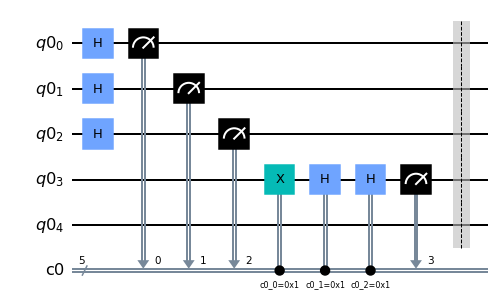

In [4]:
quantumResults, quantumCircuit = IntrinsicQuantumBB84Circuit(1, False)
quantumCircuit.draw(output='mpl')

### Quantum circuit when there is an Eve

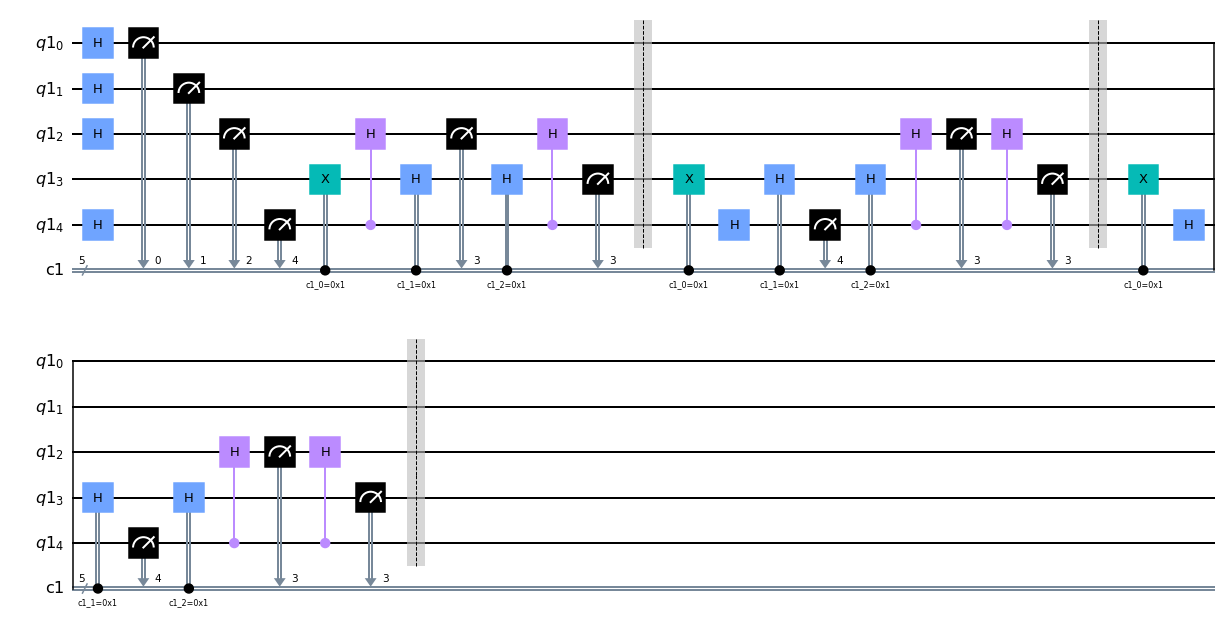

In [5]:
quantumResults, quantumCircuit = IntrinsicQuantumBB84Circuit(3, True)
quantumCircuit.draw(output='mpl')

## Function definitions

In [6]:
def BB84ProtocolQuantumRandom(messageLength, numMeasurements, isEve, Starmon):
    """
    Given the initial message length (int) it returns
    messageInABottle: randomly generated message to be communicated (A->B)
    AliceBasis: randomly generated Alice Basis (0:Z, 1:X)
    BobBasis: randomly generated Bob Basis (0:Z, 1:X)
    OutputString: either the result from the BB84 protocol if A&B have the same basis
    or an "x" if Basis(A) != Basis(B)! for each bit
    """
    
    if Starmon:
        qi_backend = QI.get_backend('Starmon-5')
    else:
        qi_backend = QI.get_backend('QX-34-L')
    
    n = 0
    messageInABottle = []
    AliceBasis = []
    BobBasis = []
    outputString = []
    sameBasisPositions = []
    quantumResults, quantumCircuit = IntrinsicQuantumBB84Circuit(numMeasurements, isEve)

    job = execute(quantumCircuit, qi_backend,shots=messageLength,memory=True)
    result = job.result()
    counts = result.get_counts()
    measure = result.get_memory()
    n_register = len(measure[0])-1
    #print(measure.shape)
    
    for n in range(messageLength):
        message_measurement = []
        AliceBasis_measurement = []
        BobBasis_measurement = []
        for m in range(numMeasurements):
            message_measurement.append(measure[n][(m+1)*n_register-0])
            AliceBasis_measurement.append(measure[n][(m+1)*n_register-1])
            BobBasis_measurement.append(measure[n][(m+1)*n_register-2])
            
        
        messageInABottle.append(int(max(set(message_measurement), key = message_measurement.count)))
        AliceBasis.append(int(max(set(AliceBasis_measurement), key = AliceBasis_measurement.count)))
        BobBasis.append(int(max(set(BobBasis_measurement), key = BobBasis_measurement.count)))
        
        if AliceBasis[n] == BobBasis[n]:
            outputString.append(int(measure[n][n_register-3]))
            sameBasisPositions.append(n)
        else:
            outputString.append("x")

    #print("Alice Basis:",AliceBasis)
    #print("Bob Basis:", BobBasis)
    return messageInABottle, AliceBasis, BobBasis, outputString, sameBasisPositions



In [7]:
def BB84KeyConstruction(message,output,goodIndices,prop,tolerance,explanation):
    """
    message: Alice starting message
    output: Bob's result through Quantum Magic
    goodIndices: bit Positions in which both basis are the same    
    prop: Proportion of common good bits to be compared
    tolerance: minimum success rate to generate a safe QK
    explanation: bool argument, if True, prints stuff

    """
    auxList = []    
    nGoodBits = len(goodIndices)
    
    
    nComparingBits = int(nGoodBits*prop)
    comparingBitPositions = random.sample(goodIndices, nComparingBits)
    if explanation:
        print("Bit Positions to compare: ",comparingBitPositions)
    
    allOkCounter = 0
    for i in range(nComparingBits):
        j = comparingBitPositions[i]
        if int(message[j])== int(output[j]):
            allOkCounter +=1
            
    for i in range(nGoodBits):
        if i not in comparingBitPositions:
            auxList.append(output[goodIndices[i]])
    
    #print(allOkCounter)
    if nComparingBits == 0:
        successRate = 1 
    else:
        successRate = float(allOkCounter/nComparingBits)
    
    if successRate < tolerance:
        print("Success rate: ",successRate)
        print("Failure")
        if explanation:
            print("Message:", message)
            print("Bob's measurements:", output)
        return successRate
    else:
        print("Success rate: ",successRate)
        print("Success!!!")
        if explanation:
            print("Message:", message)
            print("Bob's measurements:", output)
        print("QKD: ", auxList)
        return auxList

## Protocol execution

In [8]:
messageLength = 1000
prop = 0.8
tolerance = 0.8
Eve = False
Starmon = True

messageInABottle, AliceBasis, BobBasis, messageOutput, goodIndices = BB84ProtocolQuantumRandom(messageLength, 1, Eve,Starmon)

QKD = BB84KeyConstruction(messageInABottle,messageOutput,goodIndices,prop,tolerance,explanation=False)

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.4801980198019802
Failure


In [39]:
succesrates = []
for i in range(20):
    messageInABottle, AliceBasis, BobBasis, messageOutput, goodIndices = BB84ProtocolQuantumRandom(messageLength,Eve,Starmon)
    QKD = BB84KeyConstruction(messageInABottle,messageOutput,goodIndices,prop,tolerance,explanation=False)
    succesrates.append(QKD)

print('Average succes rate:            ' + str(round(np.mean(succesrates),3)))
print('Standard deviation succes rate: ' + str(round(np.std(succesrates),3)))

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.56884765625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58837890625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.56787109375
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58544921875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58837890625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.576171875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.56982421875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58251953125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58642578125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.5810546875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.58642578125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.57275390625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.5830078125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.5810546875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.564453125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.57080078125
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.57421875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.57421875
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.56640625
Failure


The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Success rate:  0.556640625
Failure
Average succes rate:            0.576
Standard deviation succes rate: 0.009


# Physical error rate analysis of BB84 circuits on Starmon-5

In [8]:
def BB84Circuits(AliceBasis, BobBasis, message):
   
    """
    Circuit Generator
    
    nbits: Self-explainatory
    AliceBasis: nqubits-length array with entries 0 (z basis) or 1 (x basis)
    BobBasis: nqubits-length array with entries 0 (z basis) or 1 (x basis)
    message: nqubits-length binary array
    """
    q = QuantumRegister(5)
    ans = ClassicalRegister(1)
    qc = QuantumCircuit(q, ans)
    
    if message == 1:
        qc.x(q[2])
    qc.barrier()
    
    if (AliceBasis + BobBasis)%2 == 1:
        qc.h(q[2])

    qc.measure(q[2],ans[0])
    
    return q, qc

## All possible 1-qubit circuits in BB84

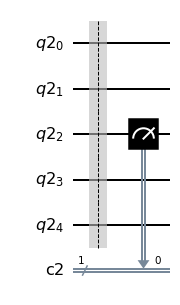

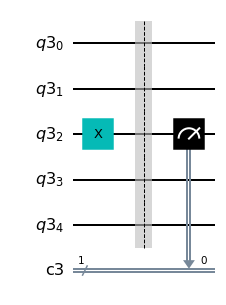

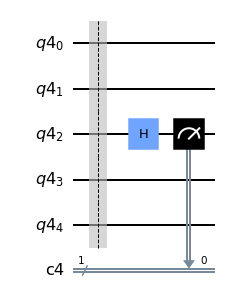

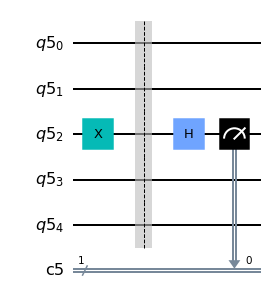

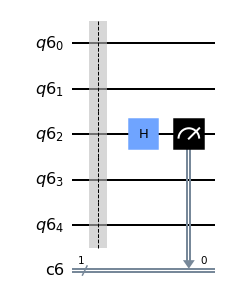

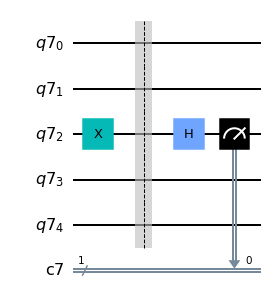

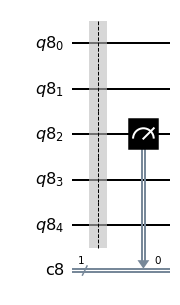

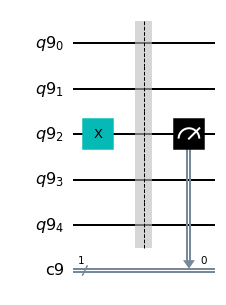

In [9]:
for AliceBasis in [0,1]:
    for BobBasis in [0,1]:
        for AliceBit in [0,1]:
            q,qc = BB84Circuits(AliceBasis, BobBasis, AliceBit)
            display(qc.draw(output='mpl'))

### Analyzing the error in all 8 circuits

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 0
Alice's basis: 0
Bob's basis: 0
Fidelity: 0.99669


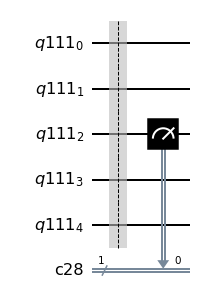

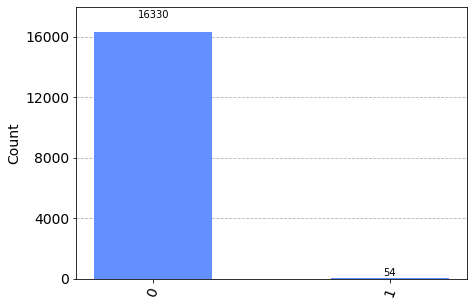

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 1
Alice's basis: 0
Bob's basis: 0
Fidelity: 0.95928


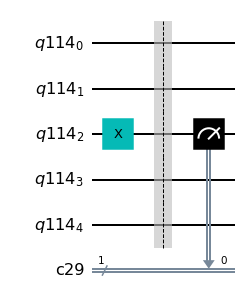

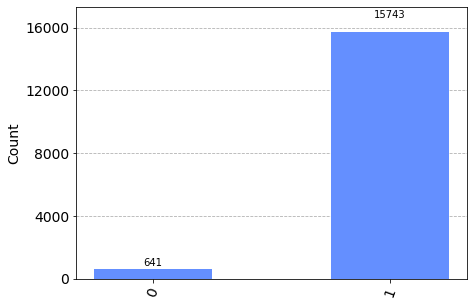

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 0
Alice's basis: 0
Bob's basis: 1


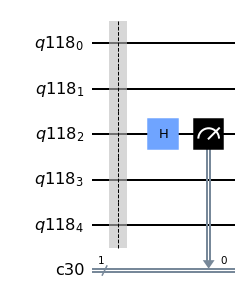

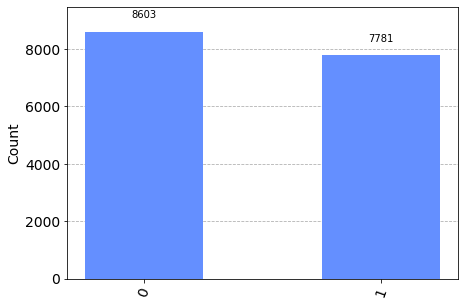

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 1
Alice's basis: 0
Bob's basis: 1


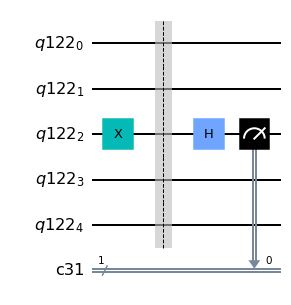

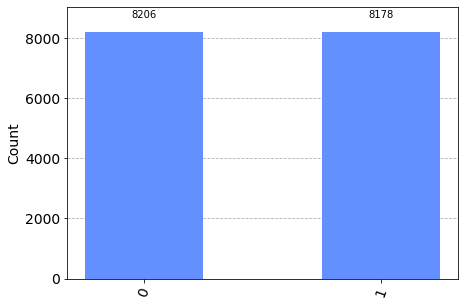

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 0
Alice's basis: 1
Bob's basis: 0


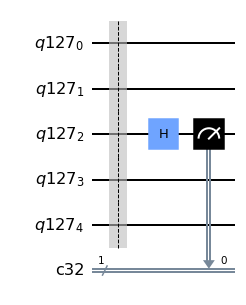

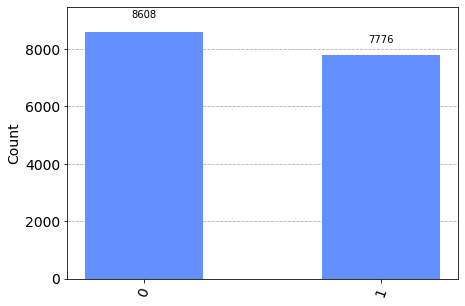

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 1
Alice's basis: 1
Bob's basis: 0


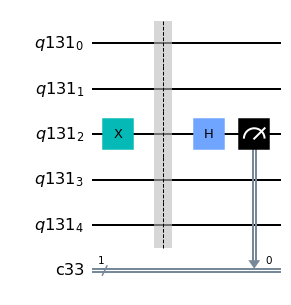

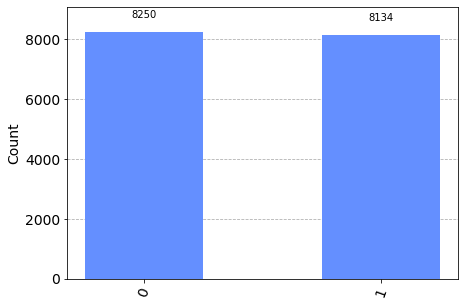

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 0
Alice's basis: 1
Bob's basis: 1
Fidelity: 0.99608


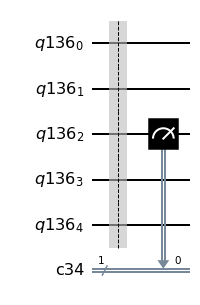

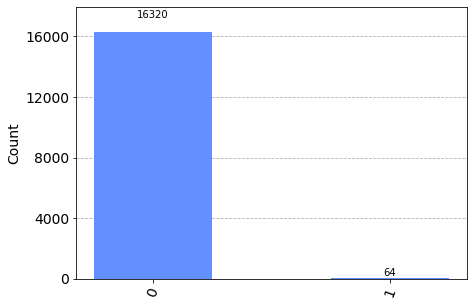

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


Alice's bit: 1
Alice's basis: 1
Bob's basis: 1
Fidelity: 0.95994


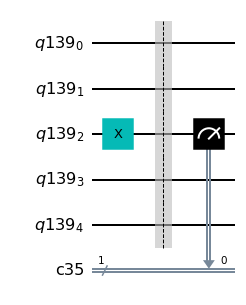

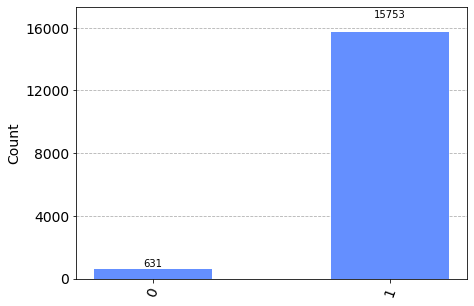

In [22]:
qi_backend = QI.get_backend('Starmon-5')

for AliceBasis in [0,1]:
    for BobBasis in [0,1]:
        for AliceBit in [0,1]:
            q,qc = BB84Circuits(AliceBasis, BobBasis, AliceBit)
            
            job = execute(qc, qi_backend,shots=16384)
            result = job.result()
            counts = result.get_counts()
            print("Alice's bit: "+str(AliceBit))
            print("Alice's basis: "+str(AliceBasis))
            print("Bob's basis: "+str(BobBasis))
            if BobBasis == AliceBasis:
                counts_0 = counts['0']
                counts_1 = counts['1']
                error = min(counts_0/counts_1, counts_1/counts_0)
                print("Fidelity: "+str(round(1-error,5)))
            display(qc.draw(output='mpl'))
            display(plot_histogram(result.get_counts(qc)))            

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand
import math as m
import operator as op
from functools import reduce

def TableShuffler(Table):
    #Input: Table, a 4xn_iter array
    #Output: Table Shuffled in columns (permutation)
    rng = np.random.default_rng()
    Shuffled = np.transpose(rng.permutation(np.transpose(Table)))
    return Shuffled

def TableFiltering(Table):
    #Input Table, a 4xn_iter array
    #Output: Table Filtered: Only those columns in which
    #Alice Basis = Bob Basis
    #i = 0: Alice Message
    #i = 1: Alice Basis
    #i = 2: Bob Basis
    #i = 3: Bob Measures
    SameBasisTable = np.zeros([4,1])
    for i in range(len(Table[0,:])):
        if Table[1,i] == Table[2,i]:
            newcol = np.zeros([4,1])
            for j in range(4):
                newcol[j,0]=Table[j,i]
            SameBasisTable = np.append(SameBasisTable,newcol,axis=1)
    SameBasisTable = np.delete(SameBasisTable,0,axis=1)
    return SameBasisTable

def TableGenerator(MesString,AliBasString,BobBasString,MeasString):
    #Intput: 4 arrays of 02 or 1s of same length
    #Output: Merge them into a table
    
    Table = np.zeros([4,len(MesString)])
    Table[0,:] = MesString
    Table[1,:] = AliBasString
    Table[2,:] = BobBasString
    Table[3,:] = MeasString
    
    return Table

def TableReorganisation(Table,n_rep):
    #Input: Filtered Table, number of iterations for repetition code
    #Output: Reorganised table by columns in groups of n_rep
    newTable = Table
    index_row = np.zeros(len(Table[0,:]),dtype = int)
    index_now = 0
    index_list = []
    for i in range(len(Table[0,:])):
        #print(i,"/",len(Table[0,:]))
        #print(index_row)
        if index_row[i] != 0:
            continue
        else:
            index_row[i] = index_now
            index_list.append(i)
            column_counter = 1
            leap = 1
            while column_counter < n_rep and i + leap < len(Table[0,:]): #We have not found all the columns or we have run out of columns
                if Table[0,i]==Table[0,i+leap] and Table[1,i]==Table[1,i+leap] and Table[1,i]==Table[1,i+leap]:
                    index_now += 1
                    column_counter += 1
                    index_row[i+leap] = index_now
                    index_list.append(i+leap)
                leap += 1
            index_now +=1
    
    #Table Reorganisation
    newTable[:] = Table[:,index_list]
    
    
    return newTable

def TableMayorityVoting(Table,n_rep):
    #Given the reorganised table, merges the columns applying mayority voting
    newTable = np.zeros([4,1])
    i = 0
    leap = 0
    while i + leap < len(Table[0,:]):
        newcol = np.zeros([4,1])
        for j in range(3):
            newcol[j,0]=Table[j,i]
        leap = 0
        cache = []
        while i + leap < len(Table[0,:]) and Table[0,i]==Table[0,i+leap] and Table[1,i]==Table[1,i+leap] and  leap <n_rep:
            cache.append(Table[3,i+leap])
            leap += 1
        
        #Mayority voting
        if len(cache) == n_rep:
            if cache.count(0) > cache.count(1):
                newcol[3,0] = 0
            else:
                newcol[3,0]= 1
        
            newTable = np.append(newTable,newcol,axis=1)
        i = i+leap
    
    newTable = np.delete(newTable,0,axis=1)
    
    return newTable

def NewStrings(Table):
    #Given the Mayority Voted Table, returns the new Alice Message and Bob Measures strings
    newAliceString = Table[0,:]
    newBobString = Table[3,:]
    
    return newAliceString,newBobString

def WholeRepetitionProcedure(AliceMess,AliceBas,BobBas,BobMeasure,n_rep):
    #Input: The 4 strings obtained through BB84 or E91 protocols, and how many repetition bits n_rep
    #Output: The new AliceKey and BobKey after the repetition protocol
    
    Table = TableGenerator(AliceMess,AliceBas,BobBas,BobMeasure)
    Shuffled = TableShuffler(Table)
    Filtered = TableFiltering(Shuffled)
    Reorganised = TableReorganisation(Filtered,n_rep)
    Mayority = TableMayorityVoting(Reorganised,n_rep)
    NewAliceKey, NewBobKey = NewStrings(Mayority)
    
    return NewAliceKey,NewBobKey

def ProbOverallFailure(probSingleFailure,N):
    #using the repetition code and mayority voting for error correcting
    #with N repetitions devoted to a single logical bit transmission
    #with each one of the single iterations having a probability of failure
    
    #returns the overallprobability of failure
    
    sum = 0
    for i in range(int(N/2)+1,N+1):
        sum += ncr(N,i)*m.pow(probSingleFailure,i)*m.pow(1-probSingleFailure,N-i)
    
    return sum

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

def NrepRequired(probSingleFailure,maxProbOverallFailure):
    #fixing the funciton attributes
    #returns the number of repetition bits required for:
    #probOverallFailure(probSingleFailure,NRepRequired) <= maxProbOverallFailure
    repBits = 1
    while(True):
        if maxProbOverallFailure >= ProbOverallFailure(probSingleFailure,repBits):
            break
        else:
            repBits += 1
    return repBits
        

In [39]:
def MeasurementProcedure():
    AliceMess = []
    AliceBas = []
    BobBas = []
    Message = []
    count = 1
    for AliceBasis in [0,1]:
        for BobBasis in [0,1]:
            for AliceBit in [0,1]:
                q,qc = BB84Circuits(AliceBasis, BobBasis, AliceBit)

                job = execute(qc, qi_backend,memory=True, shots=4096)
                result = job.result()
                measure = result.get_memory()
                
                for i in range(4096):
                    if i==0:
                        AliceMess.extend([AliceBit]*4096)
                        AliceBas.extend([AliceBasis]*4096)
                        BobBas.extend([BobBasis]*4096)
                    Message.append(measure[i][0])
                
                print('Iteration '+str(count)+'/8')
                count+=1
    return AliceMess, AliceBas, BobBas, Message

def ComparisonProtocol(prop, security, AliceMess, AliceBas, BobBas, Message):
    goodIndices = []
    for i in range(len(AliceMess)):
        if AliceBas[i] == BobBas[i]:
            goodIndices.append(i)
            
    nComparingBits = int(len(goodIndices)*prop)
    comparingBitPositions = random.sample(goodIndices, nComparingBits)
    
    allOkCounter = 0
    for i in range(nComparingBits):
        j = comparingBitPositions[i]
        if int(Message[j]) == int(AliceMess[j]):
            allOkCounter +=1
                         
    succesRate = allOkCounter/nComparingBits
    n_rep = NrepRequired(1-succesRate,security)
    return succesRate, n_rep

def FinalEvaluation(AliceKey, BobKey):
    wrong_counter = 0
    for i in range(len(AliceKey)):
        if BobKey[i] != AliceKey[i]:
            wrong_counter += 1
    Err_rate = wrong_counter/len(AliceKey)
    return Err_rate


In [41]:
qi_backend = QI.get_backend('Starmon-5')

def BB84RepititionProtocol(propComparison, DesiredSecurity):
    AliceMess, AliceBas, BobBas, Message = MeasurementProcedure()
    
    succesRate, n_rep = ComparisonProtocol(propComparison, DesiredSecurity, AliceMess, AliceBas, BobBas, Message)
    print('Succes rate was '+str(round(succesRate*100,2))+'%, so the number of repititions is: '+str(n_rep))
    
    AliceKey, BobKey = WholeRepetitionProcedure(AliceMess,AliceBas,BobBas,Message,n_rep)
    print("Alice's initial key:", AliceKey)
    print("Bob's final key:    ", BobKey)
    
    err_rate = FinalEvaluation(AliceKey, BobKey)
    print('Error rate in the final keys: '+str(err_rate))
    print('The desired error rate was:   '+str(DesiredSecurity))

    return AliceKey, BobKey

InitialKey, FinalKey = BB84RepititionProtocol(0.5, 0.0001)

The backend for which the project was created is different from the backend type given: Starmon-5. The experiment is run on backend Starmon-5.


KeyboardInterrupt: 

In [ ]:
# Create a plot of the final error rate against the number of iterations that we did
Ndatapoints = 10
AliceMess, AliceBas, BobBas, Message = MeasurementProcedure()
n_rep = np.zeros(Ndatapoints)
err_rates = np.zeros(Ndatapoints)
for i in range(Ndatapoints):
    n_rep[i] = 2*i + 1
    AliceKey, BobKey = WholeRepetitionProcedure(AliceMess,AliceBas,BobBas,Message,n_rep[i])
    err_rates[i] = FinalEvaluation(AliceKey, BobKey)
    
    print('Progress: '+str((i+1)/Ndatapoints))
    
plt.figure()
plt.plot(n_rep, err_rates)
plt.xlabel('Number of bits in majority voting')
plt.ylabel('Final error rate')
plt.show()